## Task Steps:

### Step 1: Transfer Learning with a Pretrained Model

1. Set up a widely used neural network that has been pretrained on a larger dataset.
2. Fine-tune the pretrained model to adapt its weights to our specific dataset.
3. Train the model using our dataset to improve its performance.

   - After training the model, assess its accuracy on a test set.
   - Observe the model in action by randomly selecting 5 images from the test set.
   - Calculate and analyze the confusion matrix.

### Step 2: Basic CNN Network for Reference

1. Establish a simple Convolutional Neural Network (CNN) architecture.
2. Compare the performance of this basic CNN with the pretrained model.

By following these steps, we aim to evaluate and enhance the performance of the pretrained model through transfer learning and compare it against a basic CNN for reference.


#### For the first step, we will set up AlexNet

In [13]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
import torch.nn.functional as F

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_dir = "Data/EuroSAT_RGB"
dataset = ImageFolder(root=data_dir, transform=transform)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [4]:
model = models.alexnet(pretrained=True)  
num_classes = len(dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Change the output layer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/milindbhatia/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [01:23<00:00, 2.93MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

[1,   100] loss: 0.693
[1,   200] loss: 0.339
[1,   300] loss: 0.294
[2,   100] loss: 0.209
[2,   200] loss: 0.207
[2,   300] loss: 0.178
[3,   100] loss: 0.165
[3,   200] loss: 0.170
[3,   300] loss: 0.162
[4,   100] loss: 0.126
[4,   200] loss: 0.156
[4,   300] loss: 0.133
[5,   100] loss: 0.125
[5,   200] loss: 0.115
[5,   300] loss: 0.102
[6,   100] loss: 0.094
[6,   200] loss: 0.096
[6,   300] loss: 0.090
[7,   100] loss: 0.076
[7,   200] loss: 0.073
[7,   300] loss: 0.066
[8,   100] loss: 0.077
[8,   200] loss: 0.079
[8,   300] loss: 0.080
[9,   100] loss: 0.068
[9,   200] loss: 0.060
[9,   300] loss: 0.063
[10,   100] loss: 0.063
[10,   200] loss: 0.051
[10,   300] loss: 0.057
Finished Training


We also tried setting up a ResNet50 network but it took a lot of time to run hence, we went ahead with AlexNet since it has less layers compares to other complex networks

In [6]:
model.eval()

correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print("Accuracy on test set: {:.2f}%".format(accuracy))



Accuracy on test set: 96.57%


As we can see, we observed an accuracy of 96.57% on a testset using our AlexNet - pretty impressive!
We will compare this accuracy with our basic CNN.

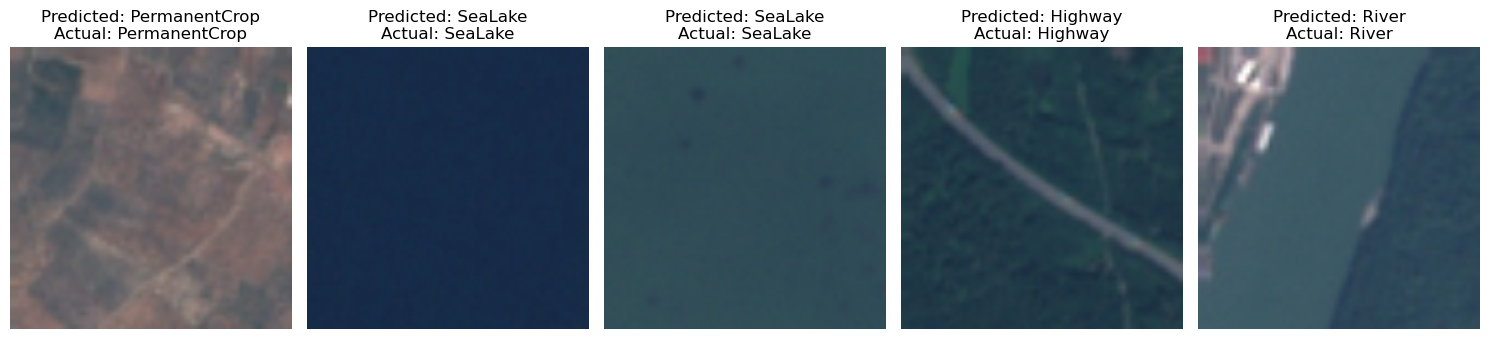

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Visualize some test images along with predicted and actual labels
num_images_to_show = 5
indices = np.random.choice(len(test_dataset), num_images_to_show, replace=False)

# Transformation to convert tensors to PIL images
to_pil = transforms.Compose([transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                            transforms.ToPILImage()])

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    image, label = test_dataset[idx]
    predicted_label = predicted_labels[idx]
    
    # Convert tensor back to PIL image
    pil_image = to_pil(image)
    
    ax = plt.subplot(1, num_images_to_show, i + 1)
    ax.imshow(pil_image)
    ax.set_title(f"Predicted: {test_dataset.dataset.classes[predicted_label]}\nActual: {test_dataset.dataset.classes[label]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

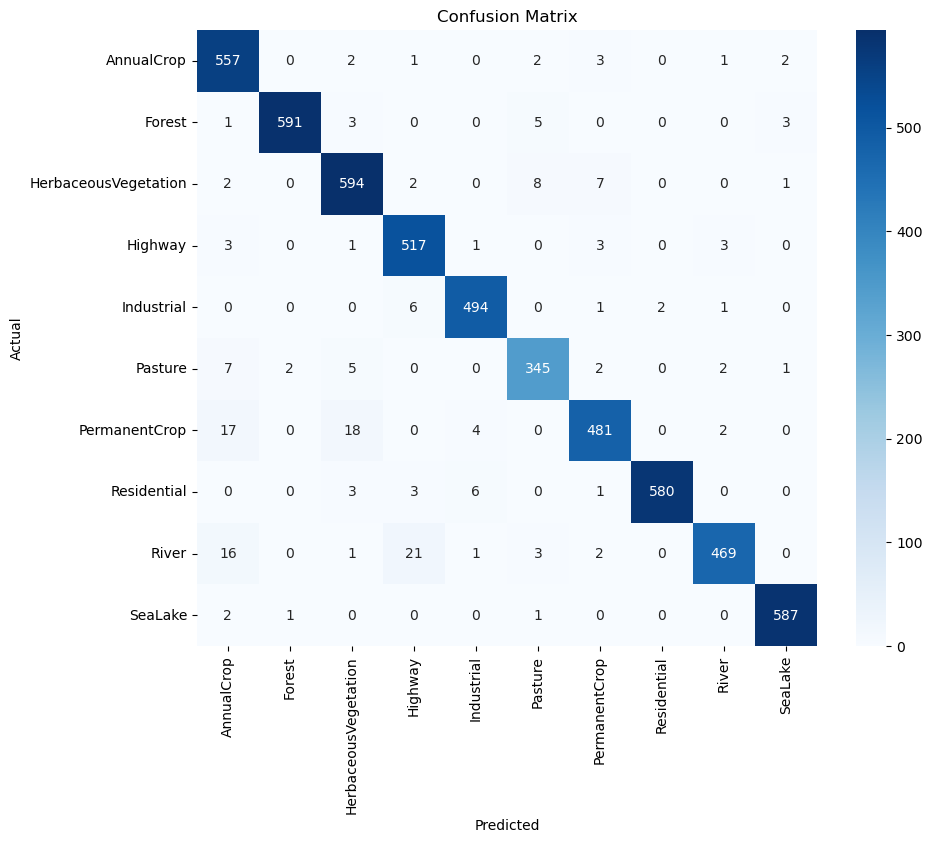

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.dataset.classes, yticklabels=test_dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### Let's also try and build our own basic CNN network and test accuracy

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for RGB
])

# Load the dataset
data_dir = "/Users/milindbhatia/Desktop/Study/Summer/Intro to ML/Take Home - Group Assignment/Intro-to-ML-project/Data/EuroSAT_RGB"
dataset = ImageFolder(root=data_dir,transform=transform)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)   # Update input channels to 3 for RGB
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(57600, 128)  # Update input features based on 64x64 RGB image
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
net = Net()

In [16]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [17]:
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

/Users/milindbhatia/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[1,   100] loss: 1.668
[1,   200] loss: 1.254
[1,   300] loss: 1.116
[2,   100] loss: 1.028
[2,   200] loss: 0.941
[2,   300] loss: 0.859
[3,   100] loss: 0.793
[3,   200] loss: 0.795
[3,   300] loss: 0.765
[4,   100] loss: 0.690
[4,   200] loss: 0.659
[4,   300] loss: 0.651
[5,   100] loss: 0.608
[5,   200] loss: 0.590
[5,   300] loss: 0.620
[6,   100] loss: 0.496
[6,   200] loss: 0.525
[6,   300] loss: 0.507
[7,   100] loss: 0.432
[7,   200] loss: 0.458
[7,   300] loss: 0.439
[8,   100] loss: 0.397
[8,   200] loss: 0.393
[8,   300] loss: 0.379
[9,   100] loss: 0.343
[9,   200] loss: 0.351
[9,   300] loss: 0.345
[10,   100] loss: 0.311
[10,   200] loss: 0.324
[10,   300] loss: 0.323
Finished Training


In [18]:
net.eval()

correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print("Accuracy on test set: {:.2f}%".format(accuracy))


Accuracy on test set: 84.00%


/Users/milindbhatia/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


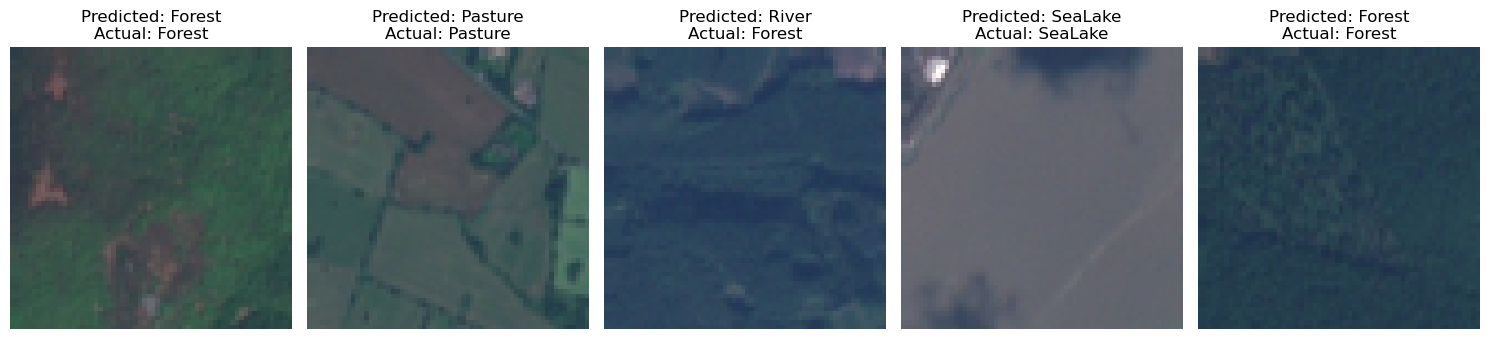

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Visualize some test images along with predicted and actual labels
num_images_to_show = 5
indices = np.random.choice(len(test_dataset), num_images_to_show, replace=False)

# Transformation to convert tensors to PIL images
to_pil = transforms.Compose([
    transforms.Normalize(mean=[-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5], std=[1 / 0.5, 1 / 0.5, 1 / 0.5]),
    transforms.ToPILImage()
])

plt.figure(figsize=(15, 10))
net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for i, idx in enumerate(indices):
        image, label = test_dataset[idx]
        
        # Move image to the appropriate device
        image = image.unsqueeze(0).to(device)
        
        # Get the predicted label from your model
        outputs = net(image)
        _, predicted_label = torch.max(outputs, 1)
        predicted_label = predicted_label.item()
        
        # Convert tensor back to PIL image
        pil_image = to_pil(image[0].cpu())
        
        ax = plt.subplot(1, num_images_to_show, i + 1)
        ax.imshow(pil_image)
        ax.set_title(f"Predicted: {test_dataset.dataset.classes[predicted_label]}\nActual: {test_dataset.dataset.classes[label]}")
        ax.axis("off")

plt.tight_layout()
plt.show()

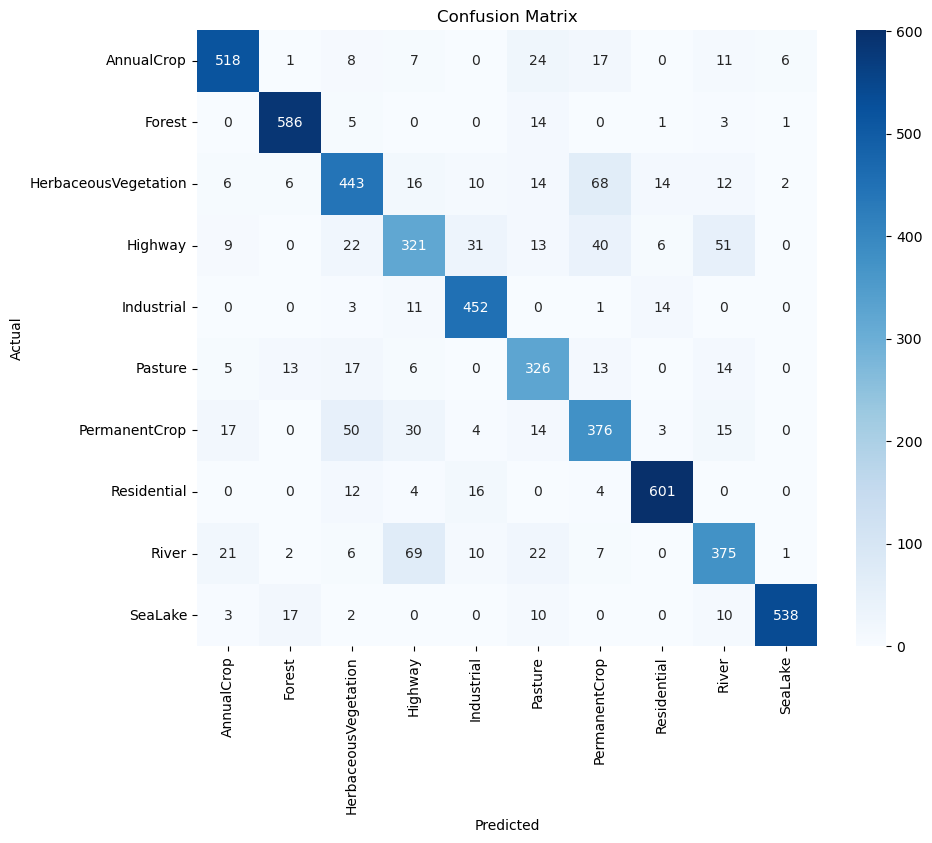

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.dataset.classes, yticklabels=test_dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**Our Basic CNN Performance:**

The basic Convolutional Neural Network (CNN) we implemented achieved an accuracy of 84% after training it for 10 epochs. This accuracy is noticeably lower compared to the performance of AlexNet. However, this outcome was anticipated due to the fact that AlexNet has been pre-trained on a significantly larger dataset. The pre-trained model's ability to capture high-level features and patterns from diverse data gives it a clear advantage in tasks like image classification.
